In [4]:
import numpy as np
from numpy import linalg 
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import qr
from scipy import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D


y = np.linspace(-2,2,401) # spatial coordinate
Ny = np.size(y)

amp1 = 1
y01 = 0.5
sigmay1 = 0.6

amp2 = 1.2
y02 = -0.5
sigmay2 = 0.3

dt = 0.1
Nt = 101
tend = dt*(Nt-1)
t = np.linspace(0,tend,Nt) # time

omega1 = 1.3
omega2 = 4.1

v1 = amp1*np.exp(-((y-y01)**2)/(2*sigmay1**2))
v2 = amp2*np.exp(-((y-y02)**2)/(2*sigmay2**2))

X = np.zeros([Ny,Nt],dtype=complex)
for tt in range(Nt):
    X[:,tt] = v1*np.cos(omega1*t[tt])+v2*np.cos(omega2*t[tt]) 

In [5]:
np.shape(X)

(401, 101)

/Users/sethgraham/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


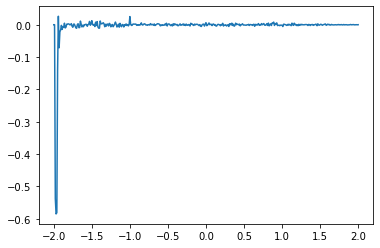

In [6]:
# Compute SVD and plot against spatial values
u, s, vh = np.linalg.svd(X)
plt.plot(y, u[1,:])

In [7]:
# QR Pivoting Method

r = 2
# Truncate u to have same dimensions
ur = u[:,:r]
Q,R,P = qr(np.transpose(ur),pivoting=True)
nspace, ntime = X.shape
timeIndex = 0

DataMean = np.mean(X,axis=1)
DataSub = X - np.tile(DataMean[:,np.newaxis],(1,ntime))

optimalSampleLocations = P[:r]
print(optimalSampleLocations)

# Do reconstruction with these measurements
OptimalMeasurements = DataSub[optimalSampleLocations,timeIndex]
# estimate coefficients of singular vectors from these measurements
cOpt = np.linalg.pinv(ur[optimalSampleLocations,:])@OptimalMeasurements

np.shape(DataSub)

[149 250]


(401, 101)

In [8]:
ny, nx = X.shape
inputs = keras.Input(shape =(nspace,))

encodedDim = 4

# add a hidden layer to encode our data

HiddenLayer = layers.Dense(encodedDim,activation = 'linear')
encoding = HiddenLayer(inputs)

encoder = keras.Model(inputs,encoding, name="encoder")
print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 401)]             0         
                                                                 
 dense (Dense)               (None, 4)                 1608      
                                                                 
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________
None


2022-08-14 18:35:30.147072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# decoder
decoder_input = layers.Input(shape = (encodedDim,))
# add output layer
outputlayer = layers.Dense(nspace,activation = 'linear')
outputs = outputlayer(decoder_input)
decoder = keras.Model(decoder_input,outputs, name="decoder")
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 401)               2005      
                                                                 
Total params: 2,005
Trainable params: 2,005
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
output_auto = decoder(encoder(inputs))
model = models.Model(inputs,output_auto)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 401)]             0         
                                                                 
 encoder (Functional)        (None, 4)                 1608      
                                                                 
 decoder (Functional)        (None, 401)               2005      
                                                                 
Total params: 3,613
Trainable params: 3,613
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# Training
TrainingInputs = np.transpose(DataSub) #mean-subtracted data
TrainingOutputs = np.transpose(DataSub)

model.compile(optimizer = 'adam', loss = 'mse')
history = model.fit(TrainingInputs,TrainingOutputs,batch_size=62,epochs= 200)

Epoch 1/200
2/2 [==============================] - 0s 3ms/step - loss: 0.2380
Epoch 2/200
2/2 [==============================] - 0s 3ms/step - loss: 0.2325
Epoch 3/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2301
Epoch 4/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2291
Epoch 5/200
2/2 [==============================] - 0s 3ms/step - loss: 0.2277
Epoch 6/200
2/2 [==============================] - 0s 3ms/step - loss: 0.2253
Epoch 7/200
2/2 [==============================] - 0s 3ms/step - loss: 0.2219
Epoch 8/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2182
Epoch 9/200
2/2 [==============================] - 0s 4ms/step - loss: 0.2138
Epoch 10/200
2/2 [==============================] - 0s 3ms/step - loss: 0.2093
Epoch 11/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2041
Epoch 12/200
2/2 [==============================] - 0s 3ms/step - loss: 0.1989
Epoch 13/200
2/2 [==============================] - 0s 3ms/st

2/2 [==============================] - 0s 2ms/step - loss: 1.3095e-04
Epoch 104/200
2/2 [==============================] - 0s 2ms/step - loss: 1.1761e-04
Epoch 105/200
2/2 [==============================] - 0s 4ms/step - loss: 1.0491e-04
Epoch 106/200
2/2 [==============================] - 0s 2ms/step - loss: 9.3137e-05
Epoch 107/200
2/2 [==============================] - 0s 3ms/step - loss: 8.3351e-05
Epoch 108/200
2/2 [==============================] - 0s 3ms/step - loss: 7.4328e-05
Epoch 109/200
2/2 [==============================] - 0s 4ms/step - loss: 6.6253e-05
Epoch 110/200
2/2 [==============================] - 0s 3ms/step - loss: 5.8808e-05
Epoch 111/200
2/2 [==============================] - 0s 4ms/step - loss: 5.2474e-05
Epoch 112/200
2/2 [==============================] - 0s 3ms/step - loss: 4.6544e-05
Epoch 113/200
2/2 [==============================] - 0s 3ms/step - loss: 4.1402e-05
Epoch 114/200
2/2 [==============================] - 0s 3ms/step - loss: 3.6641e-05
Epoch 

2/2 [==============================] - 0s 3ms/step - loss: 2.5722e-11


4/4 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Autoencoder (All Timesteps on single plot) ')

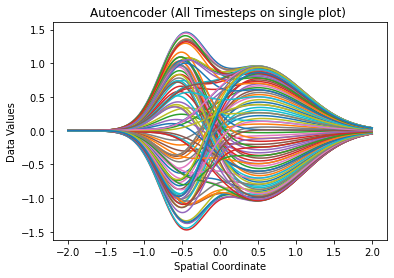

In [12]:
# Pass all of our data through the Autoencoder

TestData = np.transpose(DataSub)
ReconstructedData = model.predict(TestData)
ReconstructedDataT = np.transpose(ReconstructedData)


plt.plot(y, ReconstructedDataT)
plt.xlabel("Spatial Coordinate")
plt.ylabel("Data Values")
plt.title("Autoencoder (All Timesteps on single plot) ")

In [13]:
# Look at SVD

U,Sigma,VT = np.linalg.svd(DataSub,full_matrices=0)
# truncate SVD to the same dimension as the autoencoder
Ur = U[:,:encodedDim] 
Sigmar = np.diag(Sigma[:encodedDim])
VTr = VT[:encodedDim,:]

In [14]:
# Compare the total error from Autoencoder to SVD

ErrorSVD = np.linalg.norm(DataSub-Ur@Sigmar@VTr)
print(ErrorSVD/(nspace*ntime))

ErrorAE = np.linalg.norm(DataSub-ReconstructedDataT)
print(ErrorAE/(nspace*ntime))

# The different between the two is seemingly minimal


2.069445780963836e-18
2.318151345307491e-08


/Users/sethgraham/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'SVD (All Timesteps on single plot) ')

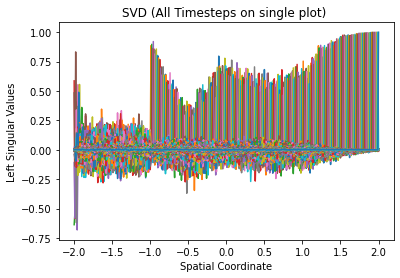

In [15]:
# Visualize SVD

plt.plot(y, u)
plt.xlabel("Spatial Coordinate")
plt.ylabel("Left Singular Values")
plt.title("SVD (All Timesteps on single plot) ")